# Set up plates for a duckweed genotypes x media growth assay

## 0. Import packages and libraries

In [1]:
import pandas as pd
import os
import json
import time
import ipywidgets as widgets

def search_up_dirs(target_dir, max_cycles):
    n = 0
    while n != max_cycles:
        curr_folder = os.path.basename(os.path.normpath(os.getcwd()))
        if curr_folder == target_dir:
            break
        os.chdir('..')
        n = n + 1
        
search_up_dirs('duckbot', 5) #Shift to duckbot
os.chdir('notebooks')

import utils.PlatePositionUtils as pp 
import utils.DuckbotExptSetupUtils as exp
from plantcv import plantcv as pcv


In [4]:
#This cell will only run if you are working at a computer connected to the Jubilee
from utils.CameraUtils import *
from utils.MachineUtils import *
# import cv2 as cv2
port = "/dev/ttyACM0"
m = MachineCommunication(port)

## 1. Select config files

### Select  Hadware-Labware config file

In [3]:
search_up_dirs('duckbot', 5) #Shift to duckbot
os.chdir('ConfigFiles')
labware_config_file_dir = os.path.join(os.getcwd(),'HardwareLabwareConfigs')
os.chdir(labware_config_file_dir)
config_opts = os.listdir(os.getcwd())
hl_choice = widgets.Dropdown(options = config_opts)
display(hl_choice)

Dropdown(options=('Default.json',), value='Default.json')

In [5]:
with open(hl_choice.value,'r') as datafile:
    hardwarelabwareconfig = json.load(datafile)
media_reservoir = hardwarelabwareconfig['media_reservoir']
tool_positions = hardwarelabwareconfig['tool_positions']
dispense_calcs = hardwarelabwareconfig['dispense_calcs']
media_dispensing_z_dict = hardwarelabwareconfig['media_dispensing_z_dict']
inoculation_loop_z_dict = hardwarelabwareconfig['inoculation_loop_z_dict']
dispense_offset =  dispense_calcs['dispense_mL'] * dispense_calcs['vol_conversion']
dispenses_per_syringe_fill = dispense_calcs['dispenses_per_syringe_fill']
duckweed_reservoir_loc = hardwarelabwareconfig["duckweed_reservoir_loc"]

### Select experimental config file

In [6]:
search_up_dirs('duckbot', 5) #Shift to duckbot
os.chdir('ConfigFiles')
expt_config_file_dir = os.path.join(os.getcwd(),'ExptConfigs')
os.chdir(expt_config_file_dir)
config_opts = os.listdir(os.getcwd())
expt_choice = widgets.Dropdown(options = config_opts)
display(expt_choice)

Dropdown(options=('Test_082422.json', 'FrondTransferForRootImaging.json', 'Expt_082222.json', 'Test_expt.json'…

In [7]:
print(f"You selected: *{expt_choice.value}*")
print("If this is not correct re-select before continuing")

You selected: *FrondTransferForRootImaging.json*
If this is not correct re-select before continuing


In [8]:
expt_setup_filepath = expt_config_file_dir + '/' + expt_choice.value

### visualize and confirm plate set up

#### Run this cell to print a visualization of your experimental design. If this isn't as expected go back and re-run the config file selection cell or go back and directly edit your experimental config file and start again

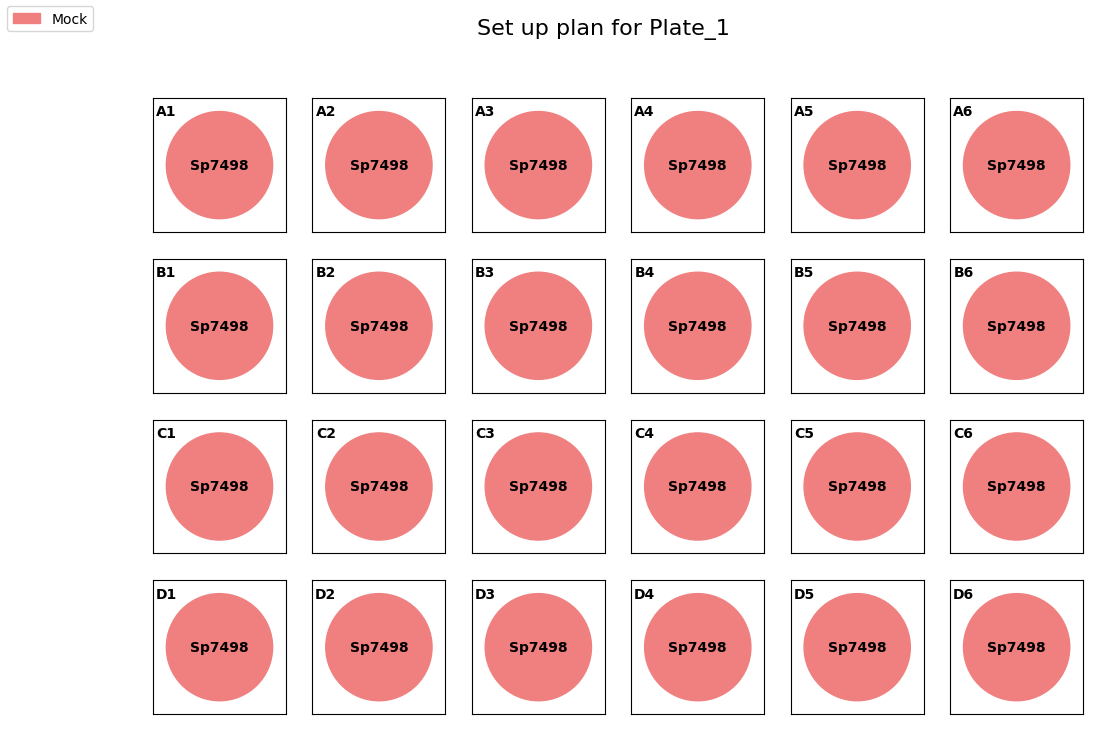

In [9]:
%matplotlib inline
with open(expt_setup_filepath,'r') as datafile:
    expt_data = json.load(datafile)
    
sample_data_dict = expt_data["sample_info"] # Turn samples list into a dataframe

df_with_well_coords = pp.add_well_coords_to_df_from_sample_data_dict(sample_data_dict)
exp.visualize_plate_set_up(df_with_well_coords)

## 2. Label 24-well plates and add to machine
Follow the instructions that are printed when you run the cells

#### Label Plates and add plates to machine

In [10]:
df = pd.DataFrame(sample_data_dict)
num_plates = df.Plate.nunique()
print(num_plates)

print("This experiment requires {} 24-well plate(s)".format(num_plates))
print("----")
lst = list(range(1,num_plates + 1))
for n in lst:
    print("Label a plate with experiment ID or initials and 'plate {}'".format(n))
print("----")
print ("Place the 24-well plate(s) in the jubilee".format(num_plates))
print ("Start at position 1 and fill empty plate slots in order")

1
This experiment requires 1 24-well plate(s)
----
Label a plate with experiment ID or initials and 'plate 1'
----
Place the 24-well plate(s) in the jubilee
Start at position 1 and fill empty plate slots in order


## 3. Dispense media
Run cells, making sure to follow the instructions that print when your run the cells

In [11]:
#Retrieve absolute positions of wells from a library and then add those coordinatest to the plate set up dataframe
df_with_well_coords = pp.add_well_coords_to_df_from_sample_data_dict(sample_data_dict)

#Reorganizes dataframe to create machine instructions sorted by media-type
media_dicts = pp.pull_list_of_well_coord_dicts_by_dfcolumn(df_with_well_coords, 'media')

In [ ]:
#Pick up syringe toolhead
media_syringe = tool_positions['media_syringe']
m.toolChange(media_syringe)

In [ ]:
# Send machine instructions

for media in media_dicts:
    m.moveTo(x=0,y=0,z=0)
    print(f"Please ensure {media['media']} is available in the machine before continuing.")
    print("Change syringe and/or needle if desired")
    while True:
        value = input("Enter 'YES' to confirm that the correct media is in position")
        if value != "YES":
            print("Please confirm")
        else:
            break
    exp.dispense_to_wells(m, media["well-coords"], dispense_offset, dispenses_per_syringe_fill, media_reservoir, media_dispensing_z_dict)

In [ ]:
# remove the media reservoir!

## 4. Transfer duckweed

### Transfer option 1: Transfer with Syringe Tool

In [ ]:
# loads in the relevant calibration files

# to use the calibration at a height of z=10, use camera_cal_z_10.json instead
with open("/home/pi/autofocus-test/JubileeAutofocus/camera_cal_z_10.json") as f:
# with open("/home/pi/autofocus-test/JubileeAutofocus/camera_cal_z_80.json") as f:
    cal = json.load(f)
matrix = np.array(cal['transform'])
size = cal['resolution']
print(matrix)
print(size)

m.transform = matrix
m.img_size = size

In [ ]:
# convert px coord to real coord
def px_to_real(x,y, absolute = False):
        x = (x / m.img_size[0]) - 0.5
        y = (y / m.img_size[1]) - 0.5
        a = 1 if absolute else 0

        return (m.transform.T @ np.array([x**2, y**2, x * y, x, y, a]))


In [ ]:
m.moveTo(z=50) # change depending on imaging eight
m.toolChange(1)
m.moveTo(z=10)

In [208]:
well = pp.fetch_well_position(1, 'A3')

m.moveTo(x=well['x'], y=well['y'])

In [11]:
#focus camera
cap = cv2.VideoCapture(0) #Note that the index corresponding to your camera may not be zero but this is the most common default

# draw a circle in the center of the frame
center = None
while center is None:
    # the first frame grab is sometimes empty
    ret, frame = cap.read()
    h, w = frame.shape[0:2]
    center = (int(w/2), int(h/2))
    print(center)

while True:
    ret, frame = cap.read()
    target = cv2.circle(frame, center, 5, (0,255,0), -1)
    cv2.imshow('Input', frame)
    c = cv2.waitKey(1)
    if c ==27: #27 is the built in code for ESC so press escape to close the window. 
        break 
        
cap.release()
cv2.destroyAllWindows()

(320, 240)


In [ ]:
# %matplotlib inline
# f = getFrame()
# frame, data = getSingleWell(f, minR=480, maxR=500)
# showFrame(frame)

In [ ]:
# test frond find & count
f = getFrame()
count, loc_data, loc_img = exp.find_and_count_fronds(f)

In [ ]:
%matplotlib inline
plt.imshow(loc_img)
if len(loc_data) > 0:
    print(loc_data[0])
    frond_px = loc_data[0]
else:
    print("didn't find a frond!")

In [ ]:
frond_off = px_to_real(frond_px[0], frond_px[1])
frond = [well['x'] - frond_off[0], well['y'] - frond_off[1]]
print(frond_off)
# move with the camera and confirm it's centered
m.moveTo(x=frond[0], y=frond[1])
showFrame(getFrame(), grid=True)

In [36]:
#pop the bed down to avoid any collisions on tool change
m.moveTo(z=80)

In [5]:
# position of photobooth vial
photobooth_reservoir = [215.5, 19]

In [7]:
# insert the photobooth and fill with water
m.toolChange(2)
print(f"Please ensure water is available in the position and the photobooth is in position 5.")
while True:
    value = input("Enter 'YES' to confirm")
    if value != "YES":
        print("Please confirm")
    else:
        break
num_mls = 1.5 # put 1.5 mL in the vial
m.moveTo(x=media_reservoir["x"], y=media_reservoir['y'])
m.moveTo(z=media_dispensing_z_dict['aspirate'])
m.move(de = dispense_offset*num_mls, s=1000)
m.moveTo(z=media_dispensing_z_dict['zero'])
m.moveTo(x=photobooth_reservoir[0], y=photobooth_reservoir[1])
m.move(de=-dispense_offset*num_mls, s=1000)

Please ensure water is available in the position and the photobooth is in position 5.
Enter 'YES' to confirmYES


In [ ]:
# pop the bed down to avoid collisions
m.moveTo(z=50)
# pick up the syringe
m.toolChange(3)
m.moveTo(x=duckweed_reservoir_loc[0], y=duckweed_reservoir_loc[1])

# syringe offset changes based on height
# need to look into this
syringe_off = [-0.3, 1.6] # pink syringe tip for picture height of 10
syringe_zero = -24 # z position where pink syringe tip touches bed plate. used for refining camera alignment 
# syringe_off = [-0.76, 4.2] # pink syringe tip for picture height of 80


In [ ]:
# find the height of the water 
# first for photobooth
# m.moveTo(x=215.5, y=47) # old design
m.moveTo(x=photobooth_reservoir[0], y=photobooth_reservoir[1]) # new design
photobooth_water_height = 8.6 # should be consistent if dispensed with machine?

In [ ]:
# pop bed down to avoid collisions after probing
m.moveTo(z=50)

In [ ]:
# then for the wells
well = pp.fetch_well_position(1, 'C1')

m.moveTo(z=50)
m.moveTo(x=well['x'], y=well['y'])

well_water_height = -14 #-12.5

In [ ]:
# pop bed down to avoid collisions after probing
m.moveTo(z=50)

In [ ]:
def aspirate_2(h):
#     m.move(de=5, s=1000) ; # 'prime' syringe
    m.moveTo(z=h + 2)
    m.dwell(1000)
    m.move(dz=-3.5, de=5) # press slightly
#     m.dwell(250)
    m.move(de=40, s=1800) # aspirate! #1200 for lemna minor
    m.move(dz=6, s=500, de=5) # aspirate!
#     m.move(dz=5, de=50, s=1000) # aspirate!

In [ ]:
# # Test automation
# # doesn't work!
# grouped_df = df.groupby('genotype')
# for field_value, sample_df in grouped_df:
# #     print("Place container of duckweed type **{0}** into jubilee and ensure lid is open".format(field_value))
#     for index,s in sample_df.iterrows():
#         plate = s["Plate"]
#         wellId = s["Well"]
#         m.moveTo(z=80)
#         m.toolChange(1)
#         well = pp.fetch_well_position(1, str(wellId))
#         m.moveTo(x=well['x'], y=well['y'])
#         f = getFrame()
#         pts = selectPoint(f, num_pts=1)
#         fronds = []
#         for pt in pts:
#             frond_off = px_to_real(pt[0], pt[1])
#             frond = [well['x'] - frond_off[0], well['y'] - frond_off[1]]
#             fronds.append(frond)
            
#         m.toolChange(3)
#         m.moveTo(x=well['x'], y=well['y'])
#         idx = 0
#         fx = fronds[idx][0]
#         fy = fronds[idx][1]
#         m.moveTo(m.moveTo(x=fx + syringe_off[0], y=fy + syringe_off[1]))
#         aspirate_2()
#         m.moveTo(z=45)
#         m.moveTo(x=215.5, y=47)
#         m.moveTo(z=6) # dip real deep in there
#         m.move(de=-12, s=500)
#         m.moveTo(z=20)
#         m.dwell(10000)
#         m.moveTo(z=45)
#         m.moveTo(x=215.5, y=147)
#         m.move(de=-35)
        
# #         print(f"Transfer {field_value} to plate {plate}, well {well}")
# #     input()
#         #print("Dispensing media of type {0} into {1}, well {2}".format(field_value,s["Plate"], s["Well"]))


In [ ]:
# take a picture to identify frond in well
well = pp.fetch_well_position(1, 'C3')
m.moveTo(z=50)

m.toolChange(1)

m.moveTo(x=well['x'], y=well['y'])

# camera is calibrated for z=10, but water surface is above the bed plate
# need to ensure surface of the water is at z=10
m.moveTo(z=10 + (well_water_height - syringe_zero)) 


In [ ]:
# try to auto find a frond
%matplotlib inline
f = getFrame()
count, loc_data, loc_img = exp.find_and_count_fronds(f)


plt.imshow(loc_img)
if len(loc_data) > 0:
    print(loc_data[0])
    frond_px = loc_data[0]
else:
    print("didn't find a frond!")

In [ ]:
# test move
frond_off = px_to_real(frond_px[0], frond_px[1])
frond = [well['x'] - frond_off[0], well['y'] - frond_off[1]]
print(frond_off)
# move with the camera and confirm it's centered
m.moveTo(x=frond[0], y=frond[1])
showFrame(getFrame(), grid=True)

In [ ]:
# now pick and place, if it all looks good!
m.toolChange(3)
m.moveTo(x=well['x'], y=well['y'])
m.moveTo(m.moveTo(x=frond[0] + syringe_off[0], y=frond[1] + syringe_off[1]))
aspirate_2(well_water_height)
m.moveTo(z=45)
m.moveTo(x=photobooth_reservoir[0], y=photobooth_reservoir[1]) 
m.moveTo(z=6) # dip into reservoir
m.move(de=-12, s=500)
m.moveTo(z=20)
m.dwell(10000)
m.moveTo(z=45)
m.moveTo(x=215.5, y=147)
m.move(de=-35)

In [ ]:
# root imaging code goes here

In [ ]:
# remove frond from photobooth
# note: auto frond finding doesn't work rn with pink pla for photobooth
m.toolChange(1)
m.moveTo(x=photobooth_reservoir[0], y=photobooth_reservoir[1]) 
m.moveTo(z=10 + (photobooth_water_height - syringe_zero))

In [ ]:
# try to auto find a frond
%matplotlib inline
f = getFrame()
count, loc_data, loc_img = exp.find_and_count_fronds(f, min_r_crop=220, max_r_crop=250)


plt.imshow(loc_img)
if len(loc_data) > 0:
    print(loc_data[0])
    frond_px = loc_data[0]
else:
    print("didn't find a frond!")

In [ ]:
# if auto finding doesn't work, can do manually:

In [ ]:
%matplotlib auto
f = getFrame()
pts = selectPoint(f, num_pts=1)

In [ ]:
fronds = []
for pt in pts:
    frond_off = px_to_real(pt[0], pt[1])
    frond = [photobooth_reservoir[0] - frond_off[0], photobooth_reservoir[1] - frond_off[1]]
    fronds.append(frond)
            
m.toolChange(3)
m.moveTo(x=photobooth_reservoir[0], y=photobooth_reservoir[1]) 
idx = 0
fx = fronds[idx][0]
fy = fronds[idx][1]
m.moveTo(m.moveTo(x=fx + syringe_off[0], y=fy + syringe_off[1]))
aspirate_2(photobooth_water_height)
m.moveTo(z=45)
m.moveTo(x=215.5, y=147)
m.move(de=-50)



In [ ]:
# pop bed down to access labware
m.moveTo(z=100)

### Consecutive Tranfser Passes
These cells will find any wells missing duckweed, and then prompt you to swap in the appropriate duckweed reservoir for transfer. Re-run the cells as many times as you like until you are satisfied with the results

In [ ]:
m.toolChange(1)
exp.check_wells(m, df_with_well_coords)

In [ ]:
exp.fill_empty_wells(m, df, duckweed_reservoir_loc, inoculation_loop_z_dict)

### Transfer option 2: Manual transfer
Run this cell to generate written instructions of what duckweed genotypes should be in which wells. 

In [ ]:
#Manual transfer

grouped_df = df.groupby('genotype')
for field_value, sample_df in grouped_df:
    print("Place container of duckweed type **{0}** into jubilee and ensure lid is open".format(field_value))
    for index,s in sample_df.iterrows():
        plate = s["Plate"]
        well = s["Well"]
        print(f"Transfer {field_value} to plate {plate}, well {well}")
    input()
        #print("Dispensing media of type {0} into {1}, well {2}".format(field_value,s["Plate"], s["Well"]))


#### Record any extra notes you'd like to add
Write down any notes about today's set up that you would like to be recorded in the set up file 

In [ ]:
notes = input()
exp.add_input_to_json(notes, "Set_up_notes", expt_setup_filepath)

### Root Imaging

In [8]:
m.moveTo(z=80)

In [9]:
m.toolChange(4)

In [ ]:
## position for photobooth in position 5
# move XY
#m.moveTo(x=221, y=82) # pink design
#m.moveTo(z=-57) # pink design
#m.moveTo(x=221, y=11) # white design
#m.moveTo(z=-55.5) # white design

In [160]:
f = getFrameCamera(idx=0, focus=1022) # 960

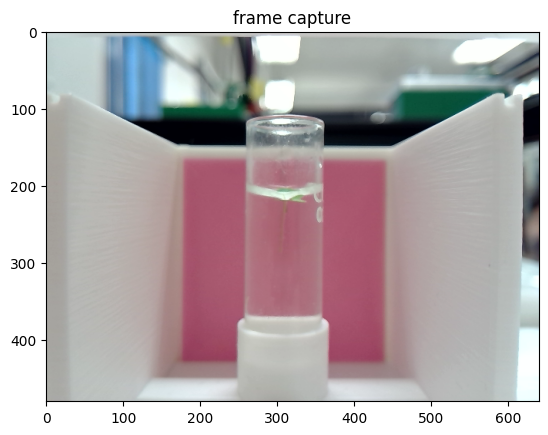

In [161]:
%matplotlib inline
showFrame(f)
# saveFrame(f, "/home/pi/whiteroot_pinkbg_whitebox.jpg")

In [22]:
# saveFrame(f, '/home/pi/Downloads/newcam-blackpaper-3.jpg')

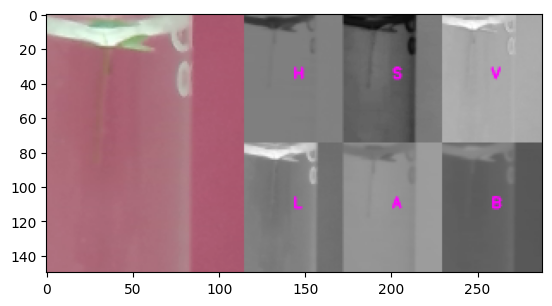

In [163]:
## test root segmentation
# crop = pcv.crop(img=f, x=275, y=200, h=150, w=115)
crop = pcv.crop(img=f, x=275, y=200, h=150, w=115)
# plt.imshow(crop)
colorspace= pcv.visualize.colorspaces(rgb_img=crop)
plt.imshow(colorspace)

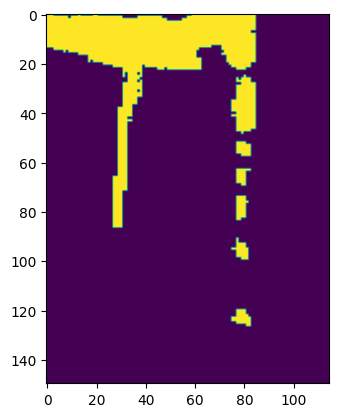

In [164]:
h = pcv.rgb2gray_hsv(crop, 'h')
h_blur = cv2.medianBlur(h, 5)
h_thresh = pcv.threshold.binary(gray_img=h, threshold=124, max_value=255, object_type='dark')
# plt.imshow(h_thresh)

v = pcv.rgb2gray_hsv(crop, 'v')
# h_blur = cv2.medianBlur(h, 5)
v_thresh = pcv.threshold.binary(gray_img=v, threshold=124, max_value=255, object_type='dark')
# plt.imshow(h_thresh)

a = pcv.rgb2gray_lab(crop, 'a')
a_blur = cv2.medianBlur(a, 5)
a_thresh = pcv.threshold.binary(gray_img=a, threshold=200, max_value=255, object_type='dark')


#with white bg
s = pcv.rgb2gray_hsv(crop, 's')
s_thresh = pcv.threshold.binary(s, 90, 255, 'dark')
# plt.imshow(s_thresh)

# working on rgb
rgb_blur = cv2.medianBlur(crop, 3)
plt.imshow(h_thresh)

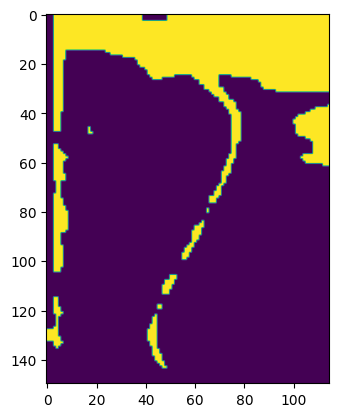

In [135]:
thresh_blur = cv2.medianBlur(h_thresh, 3)
# plt.imshow(thresh_blur)

kernel_size = 5
closing = cv2.morphologyEx(thresh_blur, cv2.MORPH_CLOSE, kernel=np.ones((kernel_size, kernel_size), np.uint8))
plt.imshow(closing)

In [ ]:
# # opening + closing to remove noise & improve root connection
# kernel_size = 5
# opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel=np.ones((kernel_size, kernel_size), np.uint8))

# kernel_size = 5
# closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel=np.ones((kernel_size, kernel_size), np.uint8))
# plt.imshow(closing)

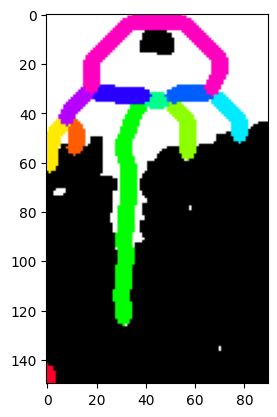

In [21]:
skeleton = pcv.morphology.skeletonize(mask=closing)
pruned_skeleton, pruned_skeleton_img, pruned_skeleton_objects = pcv.morphology.prune(skel_img=skeleton,
                                                                                     size=10,
                                                                                     mask=closing)
plt.imshow(pruned_skeleton_img)

In [ ]:
labeled_img = pcv.morphology.segment_angle(segmented_img=pruned_skeleton_img,
                                              objects=pruned_skeleton_objects,
                                              label="default")
segment_angles = pcv.outputs.observations['default']['segment_angle']['value']
root_segment_id = -1
print(segment_angles)
for idx in range(len(segment_angles)):
    if abs(segment_angles[idx]) > 50:
        root_segment_id = idx

if root_segment_id < 0:
    print("couldn't find a root!")
else:
    print(root_segment_id)

In [ ]:
labeled_img = pcv.morphology.segment_path_length(segmented_img=pruned_skeleton_img, 
                                                 objects=pruned_skeleton_objects,
                                                 label="default")

# Access data stored out from segment_path_length
path_lengths = pcv.outputs.observations['default']['segment_path_length']['value']
print(path_lengths)
print(path_lengths[root_segment_id])

### Vial removal testing

In [44]:
# position of photobooth vial
# photobooth_reservoir = [215.5, 45] # for media dispensing
photobooth_reservoir = [217.8, 42.8] # for inoculation loop pickup-- changes on removal?
photobooth_dip_height = -30 # will change if height not consistent!
m.moveTo(x=photobooth_reservoir[0], y=photobooth_reservoir[1])

In [45]:
m.moveTo(z=photobooth_dip_height)

In [46]:
m.moveTo(z=10, s=250)

In [47]:
m.moveTo(x=215, y=150)
m.moveTo(z=-42)
m.moveTo(y=125)
m.moveTo(z=10)